# (Effects on the trip duration)
## by (Gamal Samir Ali Abdalluh Shouman)

## Investigation Overview

> i focused on these features (member birth year, member gender, distance, day of week,user type)
to show if the rider and trip informations that could be used to predict the trip duration.

## Dataset Overview

> There are 170839 trips in this dataset with 18 features('duration_sec', 'start_time', 'end_time', 'start_station_id', 'start_station_name', 'start_station_latitude','start_station_longitude', 'end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type','member_birth_year', 'member_gender', 'bike_share_for_all_trip','distance_Km', 'day_of_week') these trips happened in the period between febreuary and march in 2019. There were some missing values, trips with distances equal 0 and some illogical values in the `member_birth_year` like (1878, 1910, 1920,....etc) so, i removed all these values.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# determiation the Distance Between each Two stations using its coordinates
lat_1 = df['start_station_latitude'].apply(lambda x:np.radians(x))
lat_2 = df['end_station_latitude'].apply(lambda x:np.radians(x))
lon_1 = df['start_station_longitude'].apply(lambda x:np.radians(x))
lon_2 = df['end_station_longitude'].apply(lambda x:np.radians(x))

# Haversine formula
d_lon = lon_2 - lon_1
d_lat = lat_2 - lat_1
a = d_lat.apply(lambda x:np.sin(x/2)**2) + lat_1.apply(lambda x:np.cos(x)) \
        * lat_2.apply(lambda x:np.cos(x)) * d_lon.apply(lambda x:np.sin(x/2)**2)

c = a.apply(lambda x: 2 * np.arcsin(np.sqrt(x)))

# Radius of earth in meter. Use 6371 for km
r = 6371
df['distance_Km'] = c.apply(lambda x: r * x)

In [4]:
df_clean = df.copy()
# Dropping missing values
df_clean.dropna(inplace=True)
# fixing data types
df_clean['start_time'] = pd.to_datetime(df_clean['start_time'])
df_clean['end_time'] = pd.to_datetime(df_clean['end_time'])
df_clean['member_birth_year'] = df_clean['member_birth_year'].astype(int)
df_clean['start_station_id'] = df_clean['start_station_id'].astype(str)
df_clean['end_station_id'] = df_clean['end_station_id'].astype(str)
df_clean['bike_id'] = df_clean['bike_id'].astype(str)
# dropping all values with 0 distance 
df_clean.drop(index=df_clean.loc[(df_clean['distance_Km'] == 0),:].index, inplace=True)
# dropping all values that less than 1950
df_clean.drop(index=df_clean.loc[(df_clean['member_birth_year'] < 1950),:].index, inplace=True)
# I want to make sure that all values in columns 'duration_sec' equal the difference 
# between the end time and the start time
df_clean['duration_sec'] = (df_clean['end_time'] - df_clean['start_time']).apply(lambda x: int(x.total_seconds()))

In [5]:
# adding new variabel day of the week
df_clean['day_of_week'] = df_clean['start_time'].dt.day_name()

days = ['Monday', 'Thursday', 'Wednesday', 'Tuesday', 'Friday', 'Saturday', 'Sunday']
days = pd.api.types.CategoricalDtype(ordered=True, categories=days)
df_clean['day_of_week'] = df_clean['day_of_week'].astype(days)

## (The duration)

>Most of the trips have small duration.
The log-scale of the duration the distribution looks uinmodle and its peak at 500 seconds.
After 10k second there are some outliers.

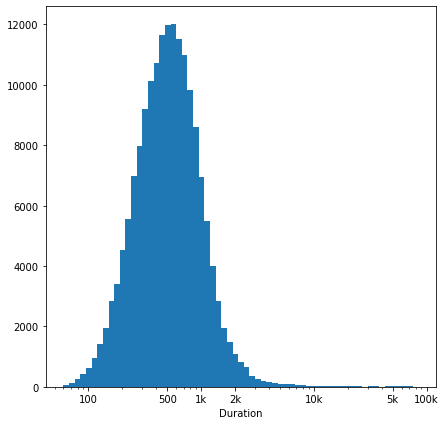

In [6]:
# putting the data on a log scale instead to get a deeper look
log_binsize = 0.05
bins =10** np.arange(np.log10(60), np.log10(84548)+log_binsize, log_binsize)

plt.figure(figsize=(7, 7))
plt.hist(data=df_clean, x='duration_sec', bins=bins)
plt.xscale('log')
plt.xticks([100, 500, 1e3, 2e3, 5e4, 1e4, 1e5], [100, 500, '1k', '2k', '5k', '10k', '100k'])
plt.xlabel('Duration');

## (the distance)

> the distribution has a long tail and most of the trips lie between 0 to 4 km.
The log-scale of the duration the distribution looks uinmodle and its peak at 2 km.

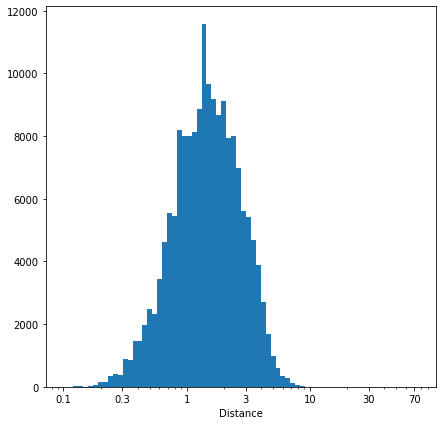

In [7]:
# putting the data on a log scale instead to get a deeper look
log_binsize = 0.04
bins =10** np.arange(-1, np.log10(70)+log_binsize, log_binsize)

plt.figure(figsize=(7, 7))
plt.hist(data=df_clean, x='distance_Km', bins=bins)
plt.xscale('log')
plt.xticks([0.1, 0.3, 1, 3, 10, 30, 70], [0.1, 0.3, 1, 3, 10, 30, 70])
plt.xlabel('Distance');

## (member_birth-year)
> * In the figure of member_birth-year we find that most of the riders were born in 1980s or 1990s and a few of them were born 1950s to 1970s.


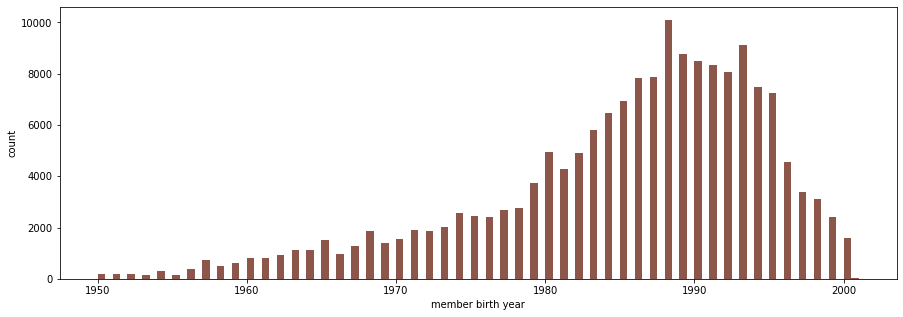

In [10]:
#Distribution of the member bith year
bins = np.arange(1950, 2001+0.5, 0.5)
base_color = sb.color_palette()[5]
plt.figure(figsize=(15, 5))
plt.hist(data=df_clean, x='member_birth_year', bins=bins, color=base_color, alpha=1)
plt.xlabel('member birth year')
plt.ylabel('count');

 ## (Trips over the weekdays)
 We find that Thursday is the most crowded day and the lowest number of trips is in Sunday The count of bike share is very less than bikes were not shared

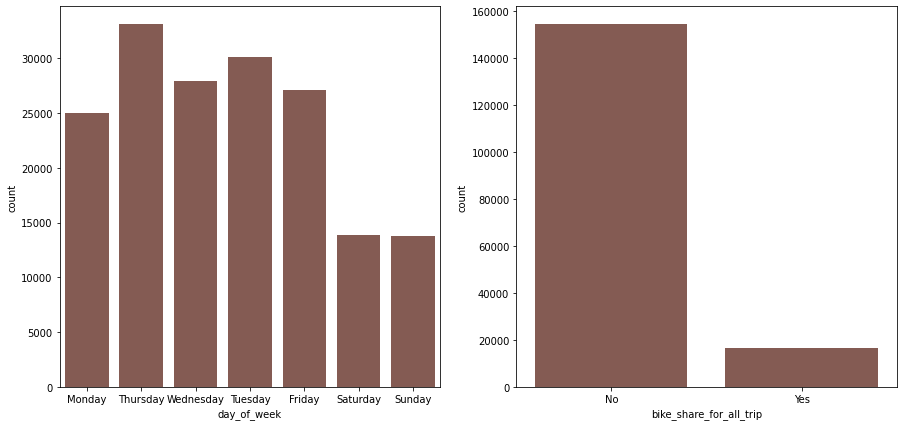

In [11]:
# plotting the two categorical variable day_of_week & bike_share_for_all_trip
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sb.countplot(data=df_clean, x='day_of_week', color=base_color, alpha=1)
plt.subplot(1, 2, 2)
sb.countplot(data=df_clean, x='bike_share_for_all_trip', color=base_color, alpha=1);

## Duration vs. Trip Distance

there is a strong positive correlation between the duration and distance variable when they were plotted in the log-scale.


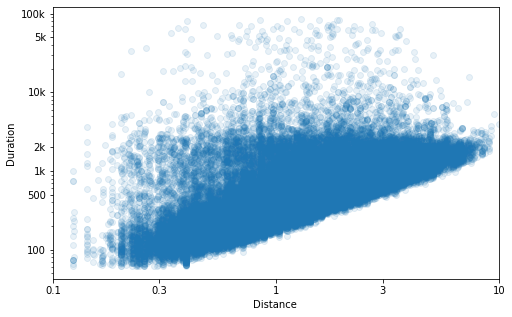

In [12]:
# creat a log transformation colums for duration and distance
def log_trans(x, inverse=False):
    """ quick function for computing log and power operations """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)


df_clean['log_duration'] = df_clean['duration_sec'].apply(log_trans)
df_clean['log_distance'] = df_clean['distance_Km'].apply(log_trans)

# plotting duration vs distance but on log-scale
plt.figure(figsize=(8,5))
plt.scatter(data=df_clean, x='log_distance', y='duration_sec', alpha=1/10)
plt.yscale('log')
plt.xlim([log_trans(.1), log_trans(10)])
plt.yticks([100, 500, 1e3, 2e3, 5e4, 1e4, 1e5], [100, 500, '1k', '2k', '5k', '10k', '100k'])
plt.xticks(log_trans(np.array([0.1, 0.3, 1, 3, 10])), [0.1, 0.3, 1, 3, 10])
plt.xlabel('Distance ')
plt.ylabel('Duration ');

## distance and Duration by User Type
- The median of the duration for males is less than femals and others and this because males have a less distance median than Them. 

- Bike_share_for_all_trip has an opposite relation of user_type, for bike sharing, bikes not be shared have longer durations than bikes be shared for the same distance.

- The median of the duration for subscribers is less than customer although the difference in distance medians is very small so, here we can say that in general subscribers have small durations than customers for the smae trip distance

- days of the week don't have any effect on the trip duration even if we saw slightly weekend trips duration median is bigger than the other days.

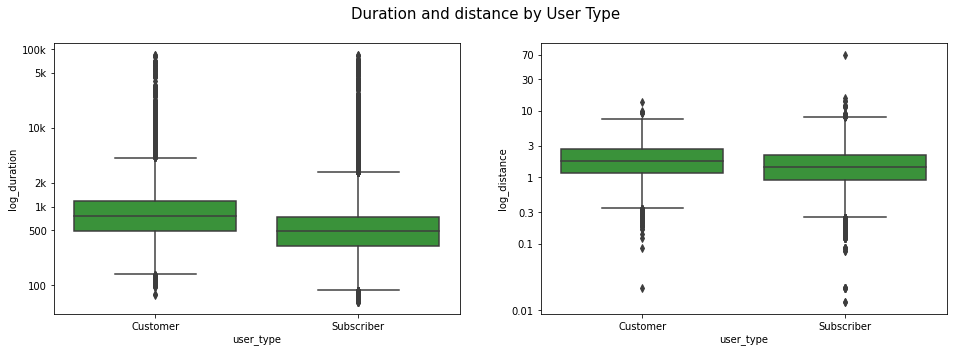

In [16]:
default_color = sb.color_palette()[2]
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 5))
plt.subplot(1, 2, 1)
ax = sb.boxplot(data=df_clean, x='user_type', y='log_duration', color=default_color)
ax.set_yticks(log_trans(np.array([100, 500, 1e3, 2e3, 5e4, 1e4, 1e5])))
ax.set_yticklabels([100, 500, '1k', '2k', '5k', '10k', '100k'])

plt.subplot(1, 2, 2)
ax = sb.boxplot(data=df_clean, x='user_type', y='log_distance', color=default_color)
ax.set_yticks(log_trans(np.array([0.01, 0.1, 0.3, 1, 3, 10, 30, 70])))
ax.set_yticklabels([0.01, 0.1, 0.3, 1, 3, 10, 30, 70]);
plt.suptitle('Duration and distance by User Type', fontsize=15);

## Distance and Duration by User Type & Weekdays
 "Saturday" has the minuimum avarage distance although "Tuesday" has the maximum avarege duration
 "Tuesday" has the maximum average distance although "Sunday" has the maximum average duration
 the customers have more average duration and distance than Subscribers

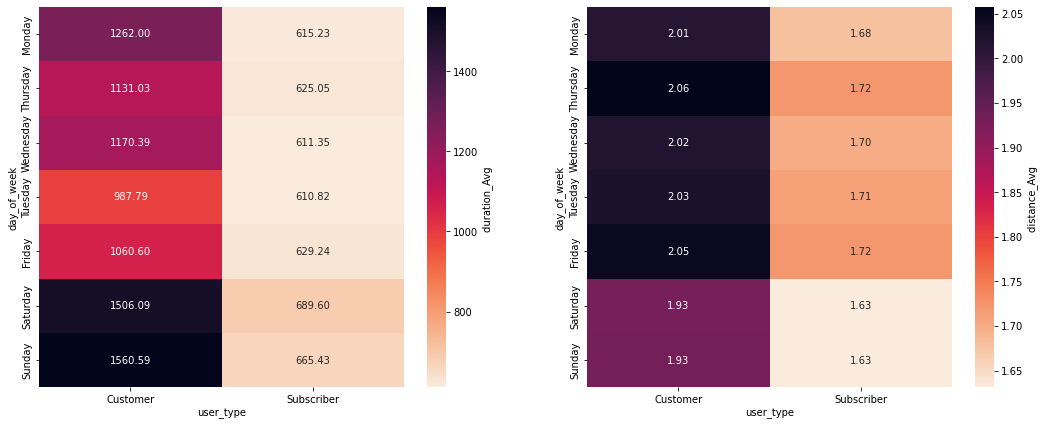

In [17]:
# "user_type", 'day_of_week' vs 'distance_Km'
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 2)
c_mean = df_clean.groupby(['day_of_week', 'user_type']).mean()['distance_Km']
c_mean = c_mean.reset_index(name='distance_Avg')
c_mean = c_mean.pivot(index='day_of_week', columns='user_type', values='distance_Avg')
sb.heatmap(c_mean, annot=True, fmt='.2f', cbar_kws={'label': 'distance_Avg '}, cmap='rocket_r');


#  "user_type ", " day_of_week"  vs 'duration_sec'
plt.subplot(1, 2, 1)
c_mean = df_clean.groupby(['day_of_week', 'user_type']).mean()['duration_sec']
c_mean = c_mean.reset_index(name='duration_Avg')
c_mean =c_mean.pivot(index='day_of_week', columns='user_type', values='duration_Avg')
sb.heatmap(c_mean, annot=True, fmt='.2f', cbar_kws={'label': 'duration_Avg '}, cmap='rocket_r');

## Distance and Duration by riders gender & Weekdays
"other" has the highest average duration and distanc and  males have the lowest

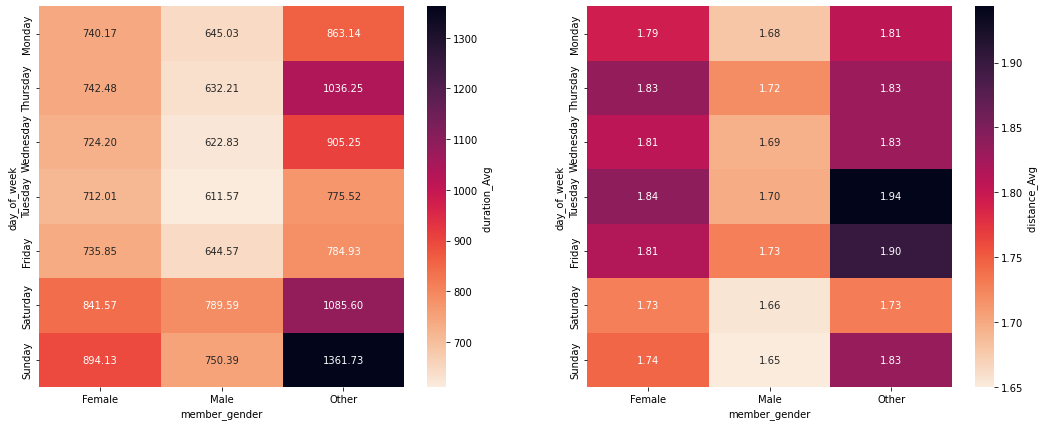

In [18]:
#  "member_gender","day_of_week" vs 'distance_Km'
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 2)
c_mean = df_clean.groupby(['day_of_week', 'member_gender']).mean()['distance_Km']
c_mean = c_mean.reset_index(name='distance_Avg')
c_mean = c_mean.pivot(index='day_of_week', columns='member_gender', values='distance_Avg')
sb.heatmap(c_mean, annot=True, fmt='.2f', cbar_kws={'label': 'distance_Avg '}, cmap='rocket_r');


#  "member_gender","day_of_week" vs 'duration_sec'
plt.subplot(1, 2, 1)
c_mean = df_clean.groupby(['day_of_week', 'member_gender']).mean()['duration_sec']
c_mean = c_mean.reset_index(name='duration_Avg')
c_mean = c_mean.pivot(index='day_of_week', columns='member_gender', values='duration_Avg')
sb.heatmap(c_mean, annot=True, fmt='.2f', cbar_kws={'label': 'duration_Avg '}, cmap='rocket_r');

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!

In [19]:
!jupyter nbconvert Ford_GoBike_Data_Explanation.ipynb --to slides --no-input

'jupyter' is not recognized as an internal or external command,
operable program or batch file.
